# Imports and Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [3]:
# get these files if on colab
# !wget -q -P /content 'https://github.com/Chelovek2002/pechenye-Yubileynoye/raw/2025d28d6fe8ff46f43a9d7480057c4493cba4e2/data/collage_words.csv'
# !wget -q -P /content 'https://github.com/Chelovek2002/pechenye-Yubileynoye/raw/2025d28d6fe8ff46f43a9d7480057c4493cba4e2/data/Categories.csv'

In [4]:
try:  # for GitHub
    words = pd.read_csv('../data/collage_words.csv').dropna()
    cats = pd.read_csv('../data/Categories.csv').dropna()
except FileNotFoundError:  # for Colab
    words = pd.read_csv('collage_words.csv').dropna()
    cats = pd.read_csv('Categories.csv').dropna()

brandwise = words.groupby(by=['Brand']).agg(lambda x: ", ".join(x)).squeeze()

In [5]:
car_brands = cats.Brand[cats.Category == "Cars"].tolist()  # list of all car brands in the survey
brandwise_cars = brandwise[brandwise.index.isin(car_brands)]  # words fore every car

In [6]:
brandwise_cars.head()

Brand
Acura       science, flame, biology, cellular telephone, a...
Audi        city, architecture, sky, urban, downtown, city...
BMW         aircraft, airplane, vehicle, airport, military...
Buick       car, vehicle, automotive, wheel, transportatio...
Cadillac    food, vegetable, market, cabbage, grow, health...
Name: Words, dtype: object

# LDA Topics Recognition

In [7]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10)
lda = LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=101)
X = count_vectorizer.fit_transform(brandwise_cars.values)

In [8]:
doc_topic = lda.fit_transform(X)  # similarity brand-to-topic

In [9]:
topic_word = lda.components_  # score how much each words is relevant to each topic
most_relevant_words = np.flip(np.argsort(topic_word, axis=1), axis=1)[:, :50]

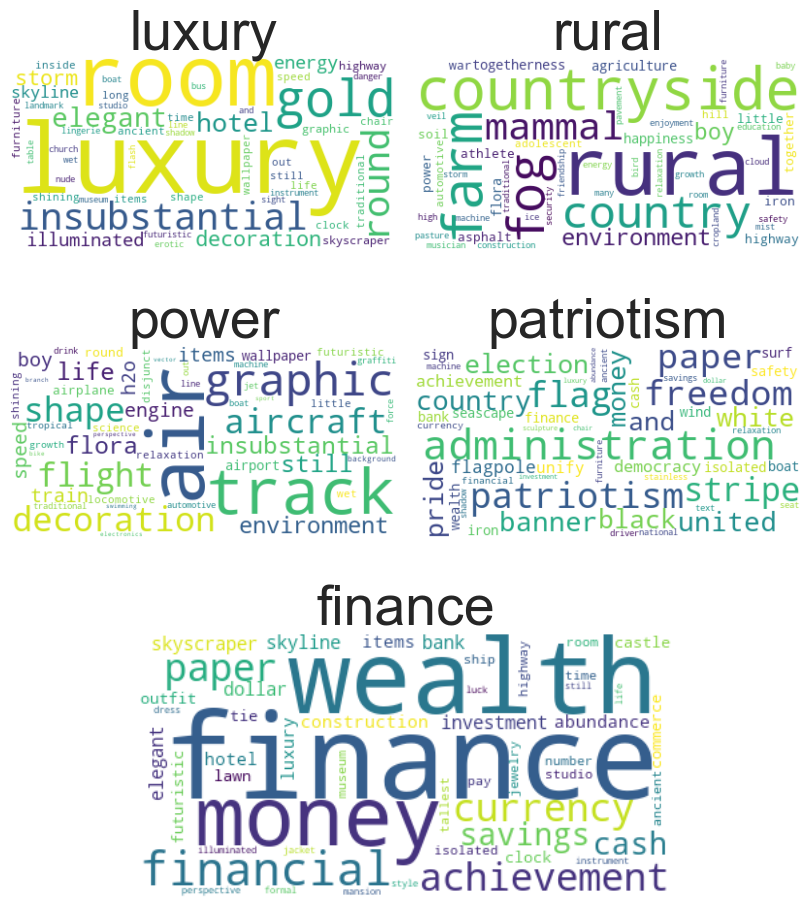

In [10]:
def plot_word_clouds(titles):
    # a nice grid
    fig, axs = plt.subplot_mosaic([[0, 1], [2, 3], [4, 4]], constrained_layout=True, figsize=(8, 9))

    for i, (topic, ax) in enumerate(zip(most_relevant_words, axs.values())):
        words, freqs = count_vectorizer.get_feature_names_out()[topic], topic_word[i, topic]
        word_freq_dict = dict(zip(words, freqs))

        cloud = WordCloud(background_color='white').generate_from_frequencies(word_freq_dict)

        ax.set_title(titles[i], fontsize=40)
        ax.imshow(cloud, interpolation='bilinear')
        ax.axis('off')

    plt.show()


# for the lda random_state=101
topic_labels = ['luxury', 'rural', 'power', 'patriotism', 'finance']
plot_word_clouds(topic_labels)

# TF-IDF Brands Description
Now let's look at the most popular words for different car brands

In [11]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.05)
tf_idf = np.array(vectorizer.fit_transform(brandwise_cars.values).todense())
ids = np.flip(tf_idf.argsort(axis=1), axis=1)

In [20]:
tf_idf_words = vectorizer.get_feature_names_out()

most_relevant_brand_words = [
    (brand, tf_idf_words[ids[i, :50]])  # ids[i,:50] is indices of top 50 words for i-th brand
    for i, brand in enumerate(car_brands)
]

most_relevant_brand_words = np.array(most_relevant_brand_words, dtype='object')

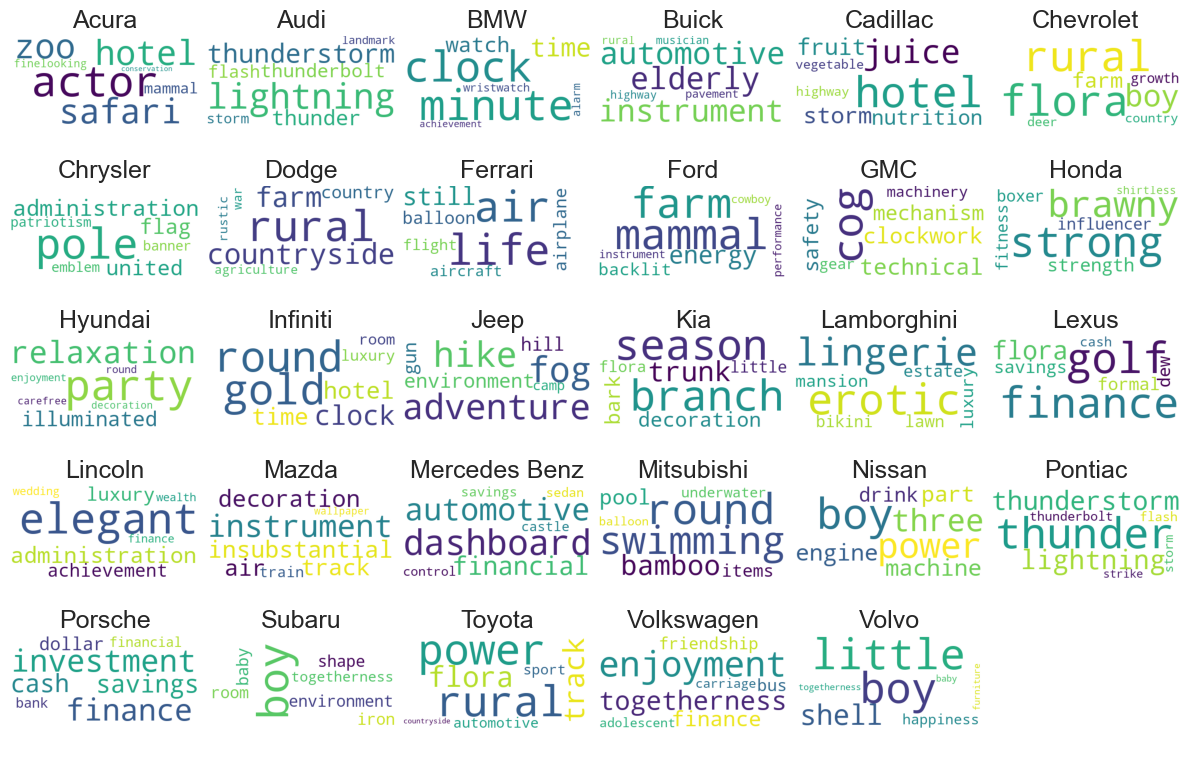

In [51]:
fig, axs = plt.subplots(5, 6, figsize=(12, 8))

for brand, words, ax in zip(car_brands, most_relevant_brand_words[:, 1], axs.flat):
    cloud = WordCloud(background_color='white', max_words=7, max_font_size=90).generate(' '.join(words))
    ax.set_title(brand, fontsize=18)
    ax.imshow(cloud)
    ax.axis('off')

# 30th subplot
axs.flat[-1].axis('off')

plt.tight_layout(h_pad=0.02, w_pad=0.5)
plt.show()

As we can see, some of these make no sense for us. Let's then create a score that says how similar a brand to a topic

In [ ]:
pd.DataFrame(tf_idf, columns=tf_idf_words, index=car_brands).head()

In [ ]:
cloud_sizes = np.count_nonzero(tf_idf, axis=1)

plt.figure(figsize=(12, 7))
plt.barh(range(len(car_brands)), cloud_sizes)
plt.yticks(range(len(car_brands)), car_brands)
plt.title('Cloud Sizes')
plt.show()

That's lenghts of clouds. So 50 is at most 10% in one case almost 20%. Is it too much? Idk

# Matching Brands and Topics

In [ ]:
most_relevant_topic_words = [count_vectorizer.get_feature_names_out()[topic] for topic in most_relevant_words]

Let's make 3 types of scores of how much car brand corresponds to a topic:
- raw
- if below 10% then 0, otherwise original value
- if below 10% then 0, otherwise 1

Note that the data is normalized to sum up to 1. Therefore, we implicitly assume that there are no types of cars than other these 5.

In [ ]:
def score_to_df(score):
    score = (score.T / score.sum(axis=1)).T
    score = pd.DataFrame(score, columns=topic_labels, index=car_brands)

    score_cleaned = score.apply(lambda x: np.where(x > 0.1, x, 0))
    score_cleaned_bi = score.apply(lambda x: np.where(x > 0.1, 1, 0))

    return score, score_cleaned, score_cleaned_bi

The jaccard metric is more suitable for binary data. However, we can still try ro use it. The implicit assumption is that all top 50 words, in both topics and brands characteristics, have the same value.

In [ ]:
def jaccard(wordset_1, wordset_2):
    intersection = set(wordset_1).intersection(set(wordset_2))
    union = set(wordset_1).union(set(wordset_2))
    return len(intersection) / len(union)

Further down we test three types of similarity metrics and compare how similar are they to each other.

## Jaccard Similarity

In [ ]:
scores_jaccard = [jaccard(bw, tw)
                  for bw in most_relevant_brand_words[:, 1]
                  for tw in most_relevant_topic_words]
scores_jaccard = np.array(scores_jaccard).reshape(29, 5)

scores_jaccard_df = score_to_df(scores_jaccard)
scores_jaccard_df[2].sample(5)

## Cosine Similarity

In [ ]:
intersection = set(vectorizer.get_feature_names_out()).intersection(count_vectorizer.get_feature_names_out())

tf_idf_lim = pd.DataFrame(tf_idf, columns=vectorizer.get_feature_names_out(), index=car_brands)
tf_idf_lim = tf_idf_lim[list(intersection)]

scores_cosine = cosine_similarity(tf_idf_lim, topic_word)
scores_cosine_df = score_to_df(scores_cosine)
scores_jaccard_df[2].sample(5)

## LDA Scores

In [ ]:
scores_lda_df = score_to_df(doc_topic)
scores_lda_df[2].sample(5)

## Comparison of metrics

In [ ]:
def res(a, b):
    print([np.isclose(a[i], b[i], rtol=0.1).sum() for i in range(3)])


s = scores_jaccard_df, scores_cosine_df, scores_lda_df
s_label = ['jac', 'cos', 'lda']
for i in range(3):
    for j in range(i + 1, 3):
        print(s_label[i], s_label[j], end=': ')
        res(s[i], s[j])